# Q1)

In [119]:
import numpy as np

from math import log, sqrt
from scipy import linalg
from scipy.special import gammaln
import matplotlib.pyplot as plt
%matplotlib inline

data = np.loadtxt("Swiss.txt")
print data.shape


(200, 7)


In [120]:
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = np.argmax(np.abs(u), axis=0)
    signs = np.sign(u[max_abs_cols, xrange(u.shape[1])])
    u *= signs
    v *= signs[:, np.newaxis]
    return u, v

In [121]:
def pca(X):
    n_components_ = 2
    n_components = 2
    n_samples, n_features = X.shape

    # Center data
    mean_ = np.mean(X, axis=0)
    X -= mean_

    U, S, V = linalg.svd(X, full_matrices=False)
    # flip eigenvectors' sign to enforce deterministic output
    U, V = svd_flip(U, V)

    components_ = V

    # Get variance explained by singular values
    explained_variance_ = (S ** 2) / n_samples
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var

    components_ = components_[:n_components]
    explained_variance_ = explained_variance_[:n_components]
    explained_variance_ratio_ = explained_variance_ratio_[:n_components]

    U = U[:, :n_components_]
    U *= S[:n_components_]
    
    return U

In [122]:
def knn(X_train, Y_train, X_test, Y_test, n=5):
    pred = np.array([])
    for a, b in X_test:
        dists = np.array([])
        for (i, j), y in zip(X_train, Y_train):
            dists = np.append(dists, (a - i)**2 + (b - j) ** 2)
        indices = np.argsort(dists)
        #print dists
        #print indices
        sum = 0
        iterator = 0
        for ind in np.argsort(dists):
            #print ind
            sum += Y_train[ind]
            iterator += 1
            if iterator >= n:
                break
        
        if sum > 0:
            pred = np.append(pred, 1.0)
        else:
            pred = np.append(pred, -1.0)
        #break
    count = 0
    for y, p in zip(Y_test, pred):
        #print y, ' -> ', p
        if y == p:
            count += 1
        #print count
    return float(count)/ float(len(Y_test)), pred

## a) seperated PCA

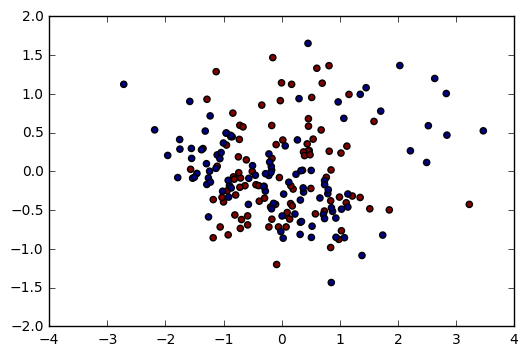

In [123]:
data_pos = data[data[:,6] > 0]
data_neg = data[data[:,6] < 0]

transformed_data = np.concatenate((pca(data_pos), pca(data_neg)), axis=0)
plt.scatter(transformed_data[:,0], transformed_data[:,1], c=data[:,6])

In [124]:
fold_num = 10

# create a random array of indeces
indeces = np.arange(len(data))
np.random.shuffle(indeces)

average = 0.0
for k in range(fold_num):
    #create train and test datasets
    X_train = np.empty((0,2), float)
    Y_train = np.empty((0,1), int)
    X_test =np.empty((0,2), float)
    Y_test = np.empty((0,1), int)
    for i in range(len(data)):
        if i >= k * len(data)/fold_num and i < (k+1) * len(data)/fold_num:
            X_test = np.vstack((X_test ,transformed_data[indeces[i],:]))
            Y_test = np.vstack((Y_test ,data[indeces[i],6]))
        else:
            X_train = np.vstack((X_train ,transformed_data[indeces[i],:]))
            Y_train = np.vstack((Y_train ,data[indeces[i],6]))
    acc, pred = knn(X_train, Y_train, X_test, Y_test)
    print '%', acc * 100
    average += float(acc) / fold_num
print 'average accuracy: %', average * 100

% 75.0
% 65.0
% 55.0
% 45.0
% 65.0
% 50.0
% 50.0
% 75.0
% 60.0
% 65.0
average accuracy: % 60.5


## b) PCA all together

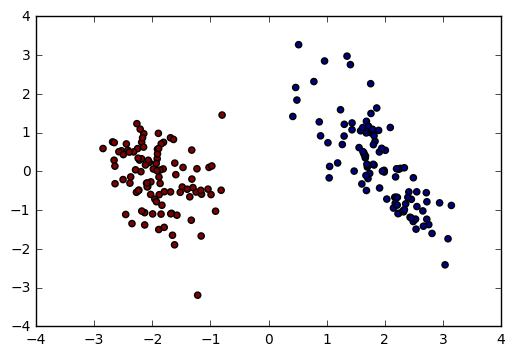

In [125]:
transformed_data = pca(data)
plt.scatter(transformed_data[:,0], transformed_data[:,1], c=data[:,6])

In [126]:
fold_num = 10

# create a random array of indeces
indeces = np.arange(len(data))
np.random.shuffle(indeces)

average = 0.0
for k in range(fold_num):
    #create train and test datasets
    X_train = np.empty((0,2), float)
    Y_train = np.empty((0,1), int)
    X_test =np.empty((0,2), float)
    Y_test = np.empty((0,1), int)
    for i in range(len(data)):
        if i >= k * len(data)/fold_num and i < (k+1) * len(data)/fold_num:
            X_test = np.vstack((X_test ,transformed_data[indeces[i],:]))
            Y_test = np.vstack((Y_test ,data[indeces[i],6]))
        else:
            X_train = np.vstack((X_train ,transformed_data[indeces[i],:]))
            Y_train = np.vstack((Y_train ,data[indeces[i],6]))
    acc, pred = knn(X_train, Y_train, X_test, Y_test)
    print '%', acc * 100
    average += float(acc) / fold_num
print 'average accuracy: %', average * 100

% 100.0
% 100.0
% 100.0
% 100.0
% 100.0
% 100.0
% 100.0
% 100.0
% 100.0
% 100.0
average accuracy: % 100.0


# Q2)

(1500, 2)


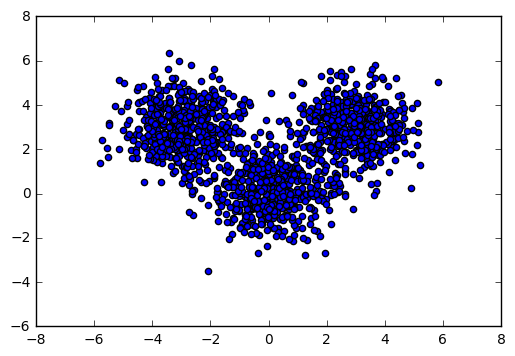

In [10]:
import scipy.io as sio
data = sio.loadmat('q3.mat')['Xtest']
print data.shape
plt.scatter(data[:,0], data[:,1])

In [24]:
reg_covar = 1e-6
tol = 1e-3
def estimate_gaussian_covariances(resp, X, nk, means, reg_covar):
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[::n_features + 1] += reg_covar
    return covariances
def compute_precision(covariances):
    n_components, n_features, _ = covariances.shape
    precisions = np.empty((n_components, n_features, n_features))
    for k, covariance in enumerate(covariances):
        try:
            cov = linalg.cholesky(covariance, lower=True)
        except linalg.LinAlgError:
            raise ValueError(estimate_precision_error_message)
        precisions[k] = linalg.solve_triangular(cov, np.eye(n_features), lower=True).T
    return precisions
def estimate_gaussian_parameters(X, resp, reg_covar):
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    covariances =  estimate_gaussian_covariances(resp, X, nk, means, reg_covar)
    return nk, means, covariances
def logsumexp(arr, axis=0):
    arr = np.rollaxis(arr, axis)
    # Use the max to normalize, as with the log this is what accumulates
    # the less errors
    vmax = arr.max(axis=0)
    out = np.log(np.sum(np.exp(arr - vmax), axis=0))
    out += vmax
    return out
def _compute_log_det(matrix,  n_features):

    n_components, _, _ = matrix.shape
    log_det = (np.sum(np.log(matrix.reshape(n_components, -1)[:, ::n_features + 1]), 1))

    return log_det

def _estimate_log_prob(X, means, precisions):
    n_samples, n_features = X.shape
    n_components, _ = means.shape
    # det(precision_chol) is half of det(precision)
    log_det = _compute_log_det(precisions, n_features)

    log_prob = np.empty((n_samples, n_components))
    for k, (mu, prec_chol) in enumerate(zip(means, precisions)):
        y = np.dot(X, prec_chol) - np.dot(mu, prec_chol)
        log_prob[:, k] = np.sum(np.square(y), axis=1)
    return -.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det

def _estimate_weighted_log_prob( X, means, precisions, weights):
    return _estimate_log_prob(X, means, precisions) + np.log(weights)

def _estimate_log_prob_resp( X, means, precisions, weights):
    weighted_log_prob = _estimate_weighted_log_prob(X, means, precisions, weights)
    log_prob_norm = logsumexp(weighted_log_prob, axis=1)
    with np.errstate(under='ignore'):
        # ignore underflow
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
    return log_prob_norm, log_resp

def _e_step( X, means, precision, weights):
    log_prob_norm, log_resp = _estimate_log_prob_resp(X, means, precision, weights)
    return np.mean(log_prob_norm), log_resp
def _m_step( X, log_resp, means, precisions, weights, covariances, reg_covar):
    n_samples, _ = X.shape
    weights, means, covariances = (estimate_gaussian_parameters(X, np.exp(log_resp),reg_covar))
    weights /= n_samples
    precisions1 = compute_precision(covariances)

    # Attributes computation
    _, n_features = means.shape

    precisions_ = np.empty(precisions1.shape)
    for k, prec in enumerate(precisions1):
        precisions_[k] = np.dot(prec, prec.T)
        
    return weights, means, covariances, precisions
def initialize_parameters(X, random_state, k):
    n_samples, _ = X.shape

    resp = np.random.mtrand._rand.rand(n_samples, k)
    resp /= resp.sum(axis=1)[:, np.newaxis]

    weights, means, covariances = estimate_gaussian_parameters(X, resp, reg_covar)
    weights /= n_samples

    precisions = compute_precision(covariances)
    
    return weights, means, covariances, precisions
def gmm(X, k, max_iter = 100):
    predict = []
    means = []
    covariances = []

    
    
    max_lower_bound = -np.infty
    converged_ = False

    random_state = None #check_random_state(random_state)

    n_samples, _ = X.shape
    
    
    weights, means, covariances, precisions = initialize_parameters(X, random_state, k)
    lower_bound_ = -np.infty

    for n_iter in range(max_iter):
        prev_lower_bound = lower_bound_

        log_prob_norm, log_resp = _e_step(X, means, precisions, weights)
        weights, means, covarainces, precisions = _m_step(X, log_resp, means, precisions, weights, covariances, reg_covar)
        lower_bound_ =  log_prob_norm

        change = lower_bound_ - prev_lower_bound

        if abs(change) < tol:
            converged_ = True
            break
        
    predict = _estimate_weighted_log_prob(X, means, precisions, weights).argmax(axis=1)
    return predict, means, covariances

In [17]:
import itertools
import matplotlib as mpl

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    


In [25]:
predict, means, covariances = gmm(data, k = 2)

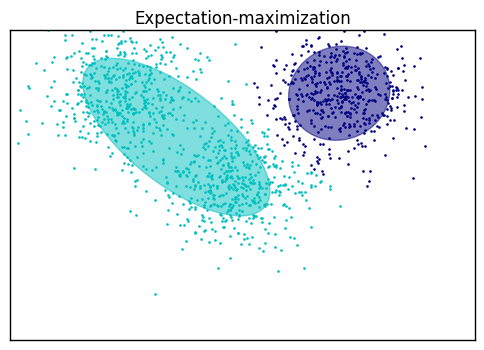

In [19]:

plot_results(data, predict, means, covariances, 0,
             'Expectation-maximization')

In [26]:
predict, means, covariances = gmm(data, k = 3)

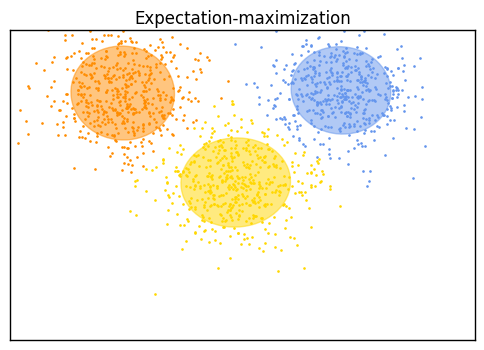

In [21]:

plot_results(data, predict, means, covariances, 0,
             'Expectation-maximization')

In [27]:
predict, means, covariances = gmm(data, k = 4)

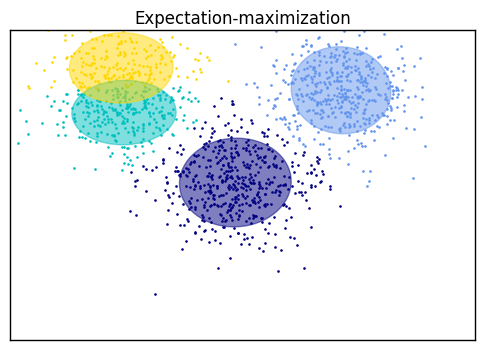

In [23]:

plot_results(data, predict, means, covariances, 0,
             'Expectation-maximization')

# Q3)